In [43]:
import numpy as np
from fxpmath import Fxp
import matplotlib.pyplot as plt
from scipy.signal import sawtooth

In [ ]:
def butterfly(a, b):
    return a + b, a - b

def generate_signal(signal_type, N, Fs):
    t = np.arange(N) / Fs
    x_real = np.zeros(N)
    x_imag = np.zeros(N)
    if signal_type == 'sin':
        F1 = 12.5e6
        x_real = np.sin(2 * np.pi * F1 * t)
    elif signal_type == 'pulse':
        x_real[0:2] = 1.0
    elif signal_type == 'random':
        x_real = 2 * np.random.rand(N) - 1
        x_imag = 2 * np.random.rand(N) - 1  
    elif signal_type == 'two_signals':
        F1 = 12.5e6
        F2 = 25e6
        signal = np.sin(2 * np.pi * F1 * t) + np.sin(2 * np.pi * F2 * t)
        x_real = signal / np.max(np.abs(signal))
    elif signal_type == 'sawtooth':
        F1 = 12.5e6
        signal = sawtooth(2 * np.pi * F1 * t)
        x_real = signal / np.max(np.abs(signal))
    else:
        print(f"Warning: Signal type '{signal_type}' not recognized. Generating zeros.")
        x_real = np.zeros(N)
    return x_real + 1j * x_imag


In [45]:
N = 8
Fs = 100e6
# sin, pulse, random, two_signals, sawtooth
selected_signal_type = 'random' 
input_signal = generate_signal(selected_signal_type, N, Fs)
fft_numpy = np.fft.fft(input_signal)


In [46]:
FXP_FORMAT_INPUT = 'fxp-s8/7'
FXP_FORMAT_TW = 'fxp-s10/9'
FXP_FORMAT_STAGES = ['fxp-s10/7', 'fxp-s11/7', 'fxp-s12/7']

tw_float = np.exp(-2j * np.pi * np.arange(N) / N)

x_fxp = Fxp(input_signal, dtype=FXP_FORMAT_INPUT)
tw_fxp = Fxp(tw_float, dtype=FXP_FORMAT_TW)

In [47]:
def fft_8p_fxp(arr, tw):
    ST1_vals = np.empty(8, dtype=complex)
    for i in range(4):
        a, b = butterfly(arr[i], arr[i+4])
        ST1_vals[i] = a.get_val()
        ST1_vals[i+4] = b.get_val()
    ST1_vals[4] *= tw[0].get_val()
    ST1_vals[5] *= tw[1].get_val()
    ST1_vals[6] *= tw[2].get_val()
    ST1_vals[7] *= tw[3].get_val()
    ST1 = Fxp(ST1_vals, dtype=FXP_FORMAT_STAGES[0])
    ST2_vals = np.empty(8, dtype=complex)
    for i in range(2):
        a, b = butterfly(ST1[i], ST1[i+2])
        c, d = butterfly(ST1[i+4], ST1[i+6])
        ST2_vals[i] = a.get_val()
        ST2_vals[i+2] = b.get_val()
        ST2_vals[i+4] = c.get_val()
        ST2_vals[i+6] = d.get_val()
    
    ST2_vals[3] *= -1j
    ST2_vals[7] *= -1j
    ST2 = Fxp(ST2_vals, dtype=FXP_FORMAT_STAGES[1])
    ST3_vals = np.empty(8, dtype=complex)
    for i in range(4):
        idx1 = i * 2
        idx2 = i * 2 + 1
        a, b = butterfly(ST2[idx1], ST2[idx2])
        ST3_vals[idx1] = a.get_val()
        ST3_vals[idx2] = b.get_val()
    ST3 = Fxp(ST3_vals, dtype=FXP_FORMAT_STAGES[2])
    bit_rev_order = [0, 4, 2, 6, 1, 5, 3, 7]
    return ST3[bit_rev_order]

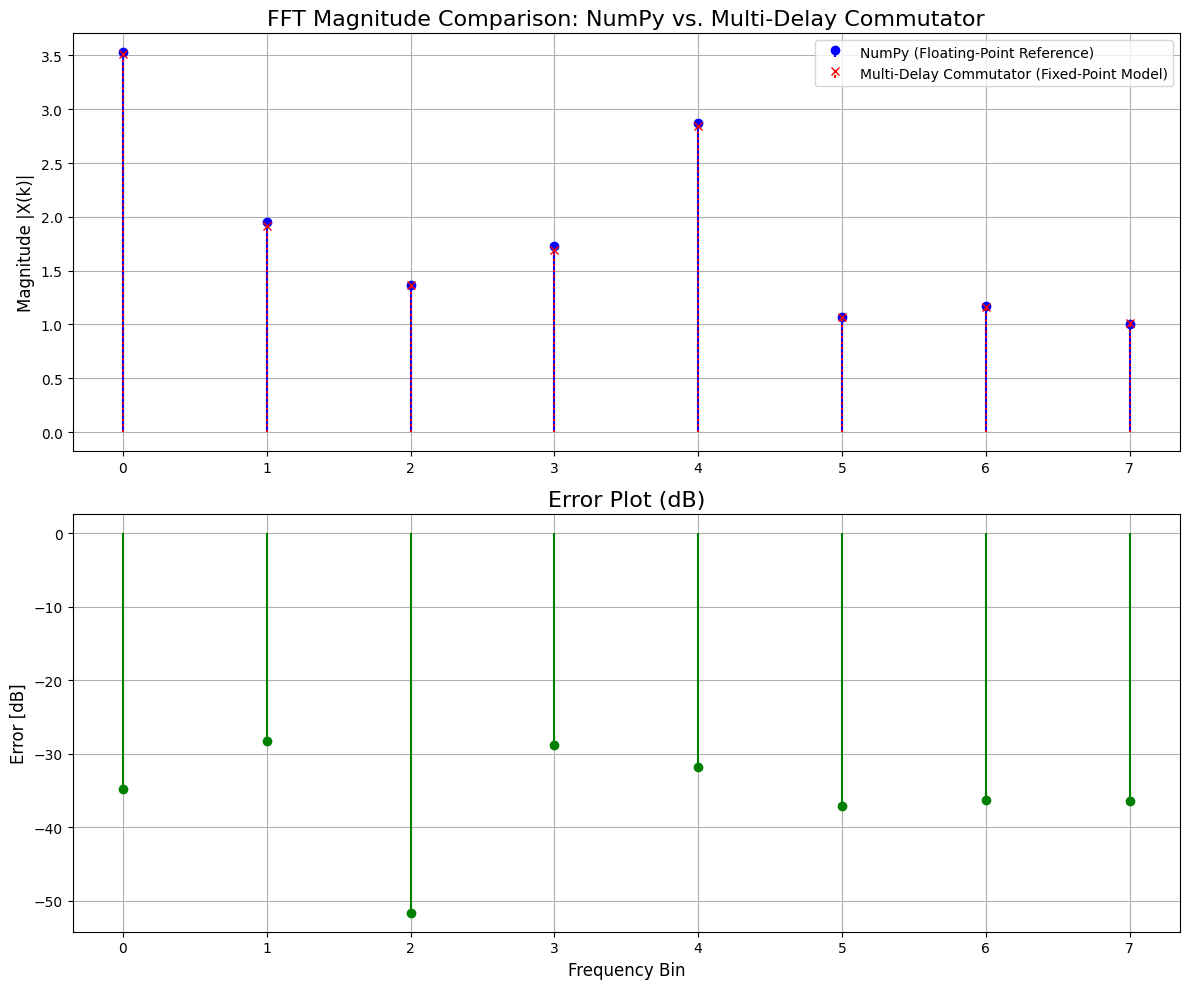

In [ ]:
fft_mdc_result = fft_8p_fxp(x_fxp, tw_fxp)
fft_mdc_numpy = fft_mdc_result.get_val()

freq_bins = np.arange(N)
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

axs[0].set_title('FFT8 Comparison: NumPy vs. Multi-Delay Commutator', fontsize=16)

axs[0].stem(freq_bins, np.abs(fft_numpy), 
            linefmt='b-', markerfmt='bo', basefmt=' ', 
            label='NumPy (Floating-Point Reference)')

axs[0].stem(freq_bins, np.abs(fft_mdc_numpy), 
            linefmt='r:', markerfmt='rx', basefmt=' ',
            label='Multi-Delay Commutator (Fixed-Point Model)')

axs[0].set_ylabel('Magnitude |X(k)|', fontsize=12)
axs[0].set_xticks(freq_bins)
axs[0].legend()
axs[0].grid(True)

error_vector = fft_numpy - fft_mdc_numpy
epsilon = 1e-20
error_magnitude_db = 20 * np.log10(np.abs(error_vector) + epsilon)

axs[1].set_title('Error Plot (dB)', fontsize=16)
axs[1].stem(freq_bins, error_magnitude_db, 
            linefmt='g-', markerfmt='go', basefmt=' ')
axs[1].set_xlabel('Frequency Bin', fontsize=12)
axs[1].set_ylabel('Error [dB]', fontsize=12)
axs[1].set_xticks(freq_bins)
axs[1].grid(True)

plt.tight_layout()